In [1]:
import numpy as np
import gzip
import os
from tqdm import tqdm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pingouin as pg
import vcf


from sklearn.preprocessing import scale
from scipy.stats import rankdata
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
from sklearn.impute import SimpleImputer

import sys
sys.path.append('/project2/mstephens/cfbuenabadn/gtex-stm/code')
sys.path.append('/project2/mstephens/cfbuenabadn/gtex-stm/code/scripts')
from get_unique_region_counts import *
from sNMF_plots import *
from get_isoforms import *
from get_unique_region_counts import *
from plot_factors import *
import tabix


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


loading modules
some more modules
custom-made modules
finished loading modules


In [2]:
def plot_factors_wrapper(rds, gene, ebpmf='ebpmf_10', strand='plus', colores=None, figsize=None, lm=True, factor_list = None, 
                         ax = None, xlim=None, plot_coords = False, lwidth=3, mute_y_axis = False):
    EF = pd.DataFrame(rds[ebpmf]['train_fit']['EF_smooth'][1:-1,:])
    EF.index = rds[ebpmf]['coords']

    if xlim is None:
        
        xlim1 = int(rds[ebpmf]['coords'][0].split(':')[1])-1000
        xlim2 = int(rds[ebpmf]['coords'][-1].split(':')[1])+1000
        xlim = (xlim1, xlim2)

    # xlim = (xlim1, xlim2)
    # print(xlim1, xlim2)
    
    EF.columns = [f'factor{str(i+1)}' for i in range(EF.shape[1])]

    if factor_list is not None:
        EF = EF[factor_list]
        EF = pd.DataFrame(EF)
        K = EF.shape[1]
        EF.columns = [f'factor{str(i)}' for i in range(1, K+1)]
    
    for factor in EF.columns:
        
        if lm:
            y = factor_lm(EF[factor], strand)
        else:
            y = np.array(EF[factor])
        EF[factor] = y
    plot_factor_tracks(EF/EF.quantile(0.99, axis=0), gene, EF.shape[1], colores = colores, figsize=figsize, ax=ax, 
                       xlim=xlim, plot_coords = plot_coords, mute_y_axis=mute_y_axis)


def plot_factor_tracks(EF, gene, K, title=None, fill=True, smooth=False, colores = None, q=0.99, figsize=None, ax=None, xlim=None, 
                       plot_coords=None, lwidth=None, mute_y_axis=False):

    EF = np.minimum(EF/EF.quantile(q, axis=0), 1)

    if colores is None:
        if K <= 5:
            colores = ['tab:blue', 'tab:orange', 'tab:green', 'goldenrod', 'tab:red'] 
        else:
            colores = sns.color_palette("tab10")
    
    if K <= 3:
        S = K
    else:
        S = K*0.8

    if figsize is None:
        figsize=(15, S)

    if ax is None:
        fig, ax = plt.subplots(nrows = K, figsize=figsize, gridspec_kw={'height_ratios': [2]*K, 
                                                                               'wspace': 0.3, 'hspace': 0.3})

    start = int(EF.index[0].split(':')[1])
    end = int(EF.index[-1].split(':')[1])
    length = EF.shape[0]
    
    coords = np.linspace(start, end, num=length)
    
    for i in range(K):
        factor = f'factor{i+1}'
        scaled_y = EF[factor]#/np.max(EF[factor])
        if fill:
            ax[i].fill_between(coords, np.zeros(len(coords)), scaled_y, color=colores[i], alpha=0.3)
#         else:
        ax[i].plot(coords, scaled_y, c=colores[i], alpha=0.9, linewidth=lwidth)
        
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        if (i < K-1) or (not plot_coords):
            ax[i].set_xticks([])
            ax[i].spines['bottom'].set_visible(False)

        if mute_y_axis:
            ax[i].spines['left'].set_visible(False)
            ax[i].set_yticks([])

        ax[i].set_xlim([xlim[0], xlim[1]])
        
        #ax[i].text(start+((end-start)*1.1), 0.9, factor, size=12)

    
        
    if title:
        fig.suptitle(title, fontsize=12, x=0.5, y=1.1)

    


###############

def plot_isoform_annotations(annotation_exons, gene, colores=None, start=None, end=None, figsize=None, lwidth=5, iso_order=None, axes=None, xlim=None):

    gene_exons = annotation_exons.loc[annotation_exons.gene_id == gene]

    if iso_order is None:
        isoforms = sorted(gene_exons.transcript_id.unique())
    else:
        isoforms = [gene + '.' + x for x in iso_order]

    isoform_dict = {}
    for i, iso in enumerate(isoforms):
        isoform_name = f'isoform_{str(i+1)}'
        df = gene_exons.loc[gene_exons.transcript_id == iso].copy()
        df['transcript_id'] =  f'{gene}.{isoform_name}'
        isoform_dict.update({isoform_name:{'df':df}})

    chrom = list(annotation_exons.chrom)[0]
    if start is None:
        start = str(np.min([int(list(gene_exons.start)[0]), int(list(gene_exons.start)[0])]) - 1000)
    if end is None:
        end = str(np.max([int(list(gene_exons.end)[-1]), int(list(gene_exons.end)[-1])]) + 1000)

    coords = [f'{chrom}:{start}', f'{chrom}:{end}']

    # print(isoform_dict)

    plot_gene_isoforms(isoform_dict, coords, color_list = colores, figsize=figsize, lwidth=lwidth, axes=axes, xlim=xlim)


def plot_gene_isoforms(isoforms_dict, coordinates, color_list = None, axes=None, figsize=None, lwidth=5, xlim=None):

    if xlim is None:
        xlim1 = int(coordinates[0].split(':')[1])
        xlim2 = int(coordinates[-1].split(':')[1])
    else:
        xlim1 = xlim[0]
        xlim2 = xlim[1]
    

    if color_list is None:
        color_list = sns.color_palette("tab10")

    K = len(isoforms_dict)

    if figsize is None:
        figsize=(20, 3)

    if axes is None:
        fig, axes = plt.subplots(K, 1, figsize=figsize)

    for i in range(K):
        isoform_df = isoforms_dict[f'isoform_{str(i+1)}']['df']
        # print(isoform_df)
        ax = axes[i]
        color = color_list[i]
        plot_isoform(isoform_df, ax, color, xlim[0], xlim[1], lwidth=lwidth)


def plot_isoform(isoform_df, ax, color, xlim1, xlim2, lwidth):
    # print(isoform_df)
    is_first = True
    for idx, row in isoform_df.iterrows():
        start = int(row.start)
        end = int(row.end)
        if is_first:
            first = end
            is_first = False
    
        ax.fill_between([start, end], [0, 0], [1, 1], color = color, zorder=2)
    
    ax.plot([first, start], [0.5, 0.5], c=color, linewidth=lwidth)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[['bottom', 'top', 'right', 'left']].set_visible(False)
    ax.set_xlim([xlim1, xlim2])

    # print(xlim1, xlim2)


def plot_barh_ax(loadings, color, ax, label='label', sort_factor = False):
    x = range(len(loadings))
    if sort_factor:
        loadings = sorted(loadings) 
    ax.barh(x, loadings, width=4, color=color, alpha=0.7)
    if sort_factor:
        median = np.median(loadings)
        middle_point = len(loadings)/2
        ax.plot([0, len(loadings)], [median, median], linestyle = '--', c='black', linewidth=2)
        ax.scatter([middle_point], [median], marker="D", c = 'black', s=10)
    
    
    
def factor_barplot_h(EL, samples, color_list, label_list, sort_factor = False, figsize=None, ylim = None, one_row = False, 
                   tissue_colors = None, print_labels=False):
    samples = samples.loc[EL.index]
    tissues = samples.tissue_id.unique()
    factors = EL.columns
    
    K = len(factors)
    N = len(tissues)

    if figsize is None:
        figsize = (N/3,K/1.2)
    
    
    

    if one_row:
        fig, axes = plt.subplots(N+1,2, figsize=figsize, gridspec_kw={'wspace': 0.05, 'hspace': 0.1}, 
                             height_ratios = (([4]*N) + [1]), width_ratios = [1.2, 10])

        for j, tissue in enumerate(tissues):
            label = label_list[j]
            tissue_samples = samples.loc[samples.tissue_id == tissue].index


            EL_sorted = EL.loc[tissue_samples].sort_values(factors[0])
            
            #loadings = list(EL.loc[tissue_samples, factors[0]])

            ax = axes[j, 1]

            ax_ = axes[j, 0]
            ax_.barh([1], [1], color = tissue_colors[j])

            ax_.axis('off')  # Hide
            ax_.margins(0, 0)
            ax_.spines['top'].set_visible(False)
            ax_.spines['bottom'].set_visible(False)
            ax_.spines['right'].set_visible(False)
            ax_.spines['left'].set_visible(False)
            ax_.set_xticks([])
            ax_.set_yticks([])

            if j == 0:

                ax_ = axes[0, 1]
    
                ax_.axis('off')  # Hide
                ax_.margins(0, 0)
                ax_.spines['top'].set_visible(False)
                ax_.spines['bottom'].set_visible(False)
                ax_.spines['right'].set_visible(False)
                ax_.spines['left'].set_visible(False)
                ax_.set_xticks([])
                ax_.set_yticks([])

            loadings = np.array(EL_sorted[factors[0]])

            median = np.median(loadings)
            middle_point = len(loadings)/2
            for i, loading in enumerate(loadings):
                ax.plot([0, loading], [i, i], c=color_list[0])

                cum_sum = loading
                for j in range(1, len(factors)):
                    loading_ = EL_sorted.iloc[i,j]
                    if j == (len(factors)-1):
                        top_bar = 1
                    else:
                        top_bar = cum_sum + loading_
                    ax.plot([cum_sum, top_bar], [i, i], c=color_list[j])
                    cum_sum += loading_
                
                # ax.plot([i, i], [loading, 1], c=color_list[1])
                
            ax.plot([median, median], [len(loadings), 0], linestyle = '--', c='black', linewidth=2)
            ax.scatter([median], [middle_point], marker="D", c = 'black', s=10, zorder=len(loadings)+2)

            axes[N, 1].spines['top'].set_visible(False)
            axes[N, 1].spines['right'].set_visible(False)
            axes[N, 1].spines['left'].set_visible(False)
            axes[N, 1].set_yticks([])
            axes[N,1].tick_params(labelsize=10)
            if print_labels:
                ax.set_xlabel(label, rotation=45)

            if ylim is None:
                axes[N, 0].set_xlim([0,1])

                ax.set_xlim([0,1])
            else:
                axes[N, 0].set_xlim(ylim)
                ax.set_ylim(ylim)
            ax.spines['top'].set_visible(False)
            
            ax.spines['left'].set_visible(False)
            ax.set_yticks([])
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])

            ax_ = axes[N, 0]
    
            ax_.axis('off')  # Hide
            ax_.margins(0, 0)
            ax_.spines['top'].set_visible(False)
            ax_.spines['bottom'].set_visible(False)
            ax_.spines['right'].set_visible(False)
            ax_.spines['left'].set_visible(False)
            ax_.set_xticks([])
            ax_.set_yticks([])
            
            # ax[0].set_ylabel(factor)
            #plot_bar_ax(loadings, color, ax, label=label, sort_factor=True)

    # axes

    else:
        fig, axes = plt.subplots(K,N+1, figsize=figsize, gridspec_kw={'wspace': 0.1, 'hspace': 0.1}, 
                             width_ratios = ([1]+([4]*N)))
    
        for i, factor in enumerate(factors):
            color = color_list[i]
            
            axes[i,0].spines['top'].set_visible(False)
            axes[i,0].spines['right'].set_visible(False)
            axes[i,0].spines['bottom'].set_visible(False)
            axes[i,0].set_xticks([])
            axes[i,0].set_ylabel(factor)
            
            factor_max = EL[factor].max()
            
            axes[i,0].set_ylim([0,factor_max])
            
            for j, tissue in enumerate(tissues):
                if i == (len(factors)-1):
                    label = label_list[j]
                else:
                    label = ''
                tissue_samples = samples.loc[samples.tissue_id == tissue].index
                loadings = list(EL.loc[tissue_samples, factor])
                
                    
                ax = axes[i,j+1]
                plot_barh_ax(loadings, color, ax, label=label, sort_factor=sort_factor)
                
                ax.set_ylim([0,factor_max])
                ax.spines['top'].set_visible(False)
                
                ax.spines['left'].set_visible(False)
                ax.set_yticks([])
                ax.spines['right'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.set_xticks([])
                
    
            #     ax.axis('off')  # Hide
                ax.margins(0, 0)
                
    
                ax.set_xlabel(label, rotation=45)



def plot_bar_ax(loadings, color, ax, label='label', sort_factor = False):
    x = range(len(loadings))
    if sort_factor:
        loadings = sorted(loadings) 
    ax.bar(x, loadings, width=4, color=color, alpha=0.7)
    if sort_factor:
        median = np.median(loadings)
        middle_point = len(loadings)/2
        ax.plot([0, len(loadings)], [median, median], linestyle = '--', c='black', linewidth=2)
        ax.scatter([middle_point], [median], marker="D", c = 'black', s=10)
    
    
    
def factor_barplot(EL, samples, color_list, label_list, tissue_colors, sort_factor = False):
    samples = samples.loc[EL.index]
    tissues = samples.tissue_id.unique()
    factors = EL.columns
    
    K = len(factors)
    N = len(tissues)
    
    
    fig, axes = plt.subplots(K+1,N+1, figsize=(N/3,K/1.5), gridspec_kw={'wspace': 0.1, 'hspace': 0.2}, 
                             width_ratios = ([1]+([4]*N)), height_ratios=[1]*K + [0.25])
    
    for i, factor in enumerate(factors):
        color = color_list[i]
        
        axes[i,0].spines['top'].set_visible(False)
        axes[i,0].spines['right'].set_visible(False)
        axes[i,0].spines['bottom'].set_visible(False)
        axes[i,0].set_xticks([])
        # axes[i,0].set_ylabel(factor)
        
        factor_max = EL[factor].max()
        
        axes[i,0].set_ylim([0,factor_max])
        
        for j, tissue in enumerate(tissues):
            if i == (len(factors)-1):
                label = label_list[j]
            else:
                label = ''
            tissue_samples = samples.loc[samples.tissue_id == tissue].index
            loadings = list(EL.loc[tissue_samples, factor])
            
                
            ax = axes[i,j+1]
            plot_bar_ax(loadings, color, ax, label=label, sort_factor=sort_factor)
            
            ax.set_ylim([0,factor_max])
            ax.spines['top'].set_visible(False)
            
            ax.spines['left'].set_visible(False)
            ax.set_yticks([])
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])
            

        #     ax.axis('off')  # Hide
            ax.margins(0, 0)
            

            # ax.set_xlabel(label, rotation=45)


            ax_ = axes[K, j+1]
            ax_.barh([1], [1], color = tissue_colors[j])
    
            ax_.axis('off')  # Hide
            ax_.margins(0, 0)
            ax_.spines['top'].set_visible(False)
            ax_.spines['bottom'].set_visible(False)
            ax_.spines['right'].set_visible(False)
            ax_.spines['left'].set_visible(False)
            ax_.set_xticks([])
            ax_.set_yticks([])

    
            axes[K, 0].axis('off')  # Hide
            axes[K, 0].margins(0, 0)


In [3]:
participant = pd.read_csv('../data/participant.tsv', sep='\t', index_col=0)
gtex_samples = pd.read_csv('../code/config/samples.tsv', sep='\t', index_col=0)

tissue_sub_list = sorted(['Brain_Anterior_cingulate_cortex_BA24',
                      'Brain_Cortex',
                      'Brain_Frontal_Cortex_BA9',
                      'Brain_Putamen_basal_ganglia',
                      'Skin_Not_Sun_Exposed_Suprapubic',
                      'Liver',
                      'Lung', 
                      'Heart_Atrial_Appendage', 
                      'Muscle_Skeletal',
                      'Whole_Blood'])

In [4]:
def load_ebpmf_gene(gene_id):
    readRDS = ro.r['readRDS']
    df = readRDS(f'ebpmf_models/filtered/RDS/{gene_id}.rds')
    with (ro.default_converter + pandas2ri.converter).context():
        pd_from_r_df = ro.conversion.get_conversion().rpy2py(df)

    junc_file = '/project2/mstephens/cfbuenabadn/gtex-stm/code/junctions.tab.gz'
    coords = pd_from_r_df['coords']
    junctions_bed = get_junctions_bed(coords, junc_file, gene_id)

    output = {'rds':pd_from_r_df, 'junctions_bed':junctions_bed}

    return output

import rpy2
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

colores = np.array(sns.color_palette("tab10"))


def get_best_snp_record(vcf, phenotype, QTLs):
    
    chrom =QTLs.loc[phenotype, 'phe_chr'] 
    location = int(QTLs.loc[phenotype, 'var_id'].split(':')[1])
    
    location1 = int(QTLs.loc[phenotype, 'var_from'])
    location2 = int(QTLs.loc[phenotype, 'var_to'])
    
    record_list = []
    for record in vcf.fetch(chrom, location1-1, location2+1):  
        if record.POS == location:
#             print(chrom, location)
            return [record]
        record_list.append(record)
        
    return record_list

def get_snp_record(vcf, var_id):
    chrom, position, ref, alt, _ = var_id.split('_')
    position = int(position)
    record_out = None
    for record in vcf.fetch(chrom, position-1, position+1):  
        if (record.POS == position) and (record.REF == ref) and (alt in record.ALT):
            record_out = record
    return record_out
#             print(chrom, location)

In [5]:
 gtex_vcf = vcf.Reader(open('/project2/yangili1/cfbuenabadn/ChromatinSplicingQTLs/code/GTEx/data/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_866Indiv.vcf.gz', 'br'))

In [6]:
def get_best_snp_record(vcf, phenotype, QTLs):
    
    chrom =QTLs.loc[phenotype, 'phe_chr'] 
    location = int(QTLs.loc[phenotype, 'var_id'].split(':')[1])
    
    location1 = int(QTLs.loc[phenotype, 'var_from'])
    location2 = int(QTLs.loc[phenotype, 'var_to'])
    
    record_list = []
    for record in vcf.fetch(chrom, location1-1, location2+1):  
        if record.POS == location:
#             print(chrom, location)
            return [record]
        record_list.append(record)
        
    return record_list

In [7]:
def plot_gene(gene, tissue, var_id, plot_var = True, smooth=50, xlim = False, counts = 'filtered', var_h = 3):
    counts = pd.read_csv(f'../code/coverage/counts_{counts}/{gene}.csv.gz', index_col=0)
    counts_ba9 = counts.loc[[x for x in counts.index if tissue in x]]
    counts_ba9.index = ['-'.join(x.split('-')[:2]) for x in counts_ba9.index]

    
    
    # var_id = 'chr12_123940602_C_T_b38'
    var_loc = int(var_id.split('_')[1])
    rec_ = get_snp_record(gtex_vcf, var_id)
    ref = rec_.REF
    alt = str(rec_.ALT[0])
    hom_refs = pd.Index([x.sample for x in rec_.get_hom_refs()]).intersection(counts_ba9.index)
    hets = pd.Index([x.sample for x in rec_.get_hets()]).intersection(counts_ba9.index)
    hom_alts = pd.Index([x.sample for x in rec_.get_hom_alts()]).intersection(counts_ba9.index)
    
    total_samples = hom_refs.union(hets).union(hom_alts)
    samples_intersect = counts_ba9.index.intersection(total_samples)
    
    
    rpkm_ba9 = 1e9*counts_ba9.divide(counts_ba9.sum(axis=1), axis=0)/counts_ba9.shape[1]

    first_pos = int(counts.columns[0].split(':')[1])

    print(var_loc)
    print(first_pos)
    fig, ax = plt.subplots(figsize = (10, 1.5))

    
    mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_alts)].mean(axis=0))
    smoothed_mean = [np.mean(mean_counts[i:i+smooth]) for i in range(len(mean_counts))]
    x = range(first_pos, first_pos+len(smoothed_mean))
    ax.plot(x, smoothed_mean, c = 'silver', label = 'G/G')
    
    mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hets)].mean(axis=0))
    smoothed_mean = [np.mean(mean_counts[i:i+smooth]) for i in range(len(mean_counts))]
    ax.plot(x, smoothed_mean, c='gray', label='G/A')
    
    mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_refs)].mean(axis=0))
    smoothed_mean = [np.mean(mean_counts[i:i+smooth]) for i in range(len(mean_counts))]
    ax.plot(x, smoothed_mean, c='black', label = 'A/A')
    
    # var_loc = 56076841
    if plot_var:
        ax.plot([var_loc, var_loc], [0, var_h], linestyle='--', c='red', linewidth=2)
    ax.legend(frameon=False)
    ax.set_xlabel('chr19')
    # ax.set_yticks([np.log1p(0), np.log1p(1), np.log1p(10)])
    # ax.set_yticklabels(['0', '1', '10'])
    ax.set_ylabel('normalized counts')

    if xlim:
        ax.set_xlim([first_pos, first_pos + xlim])
    
    # ax.set_xlim([142130000, 142160000])

23383982
23380859


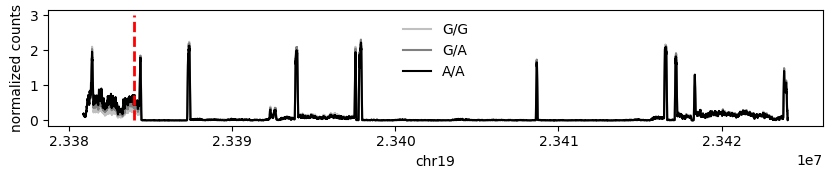

In [12]:
plot_gene('ENSG00000204219', 'Skin_Not_Sun_Exposed_Suprapubic', 'chr1_23383982_C_T_b38', )

121824730
121894351


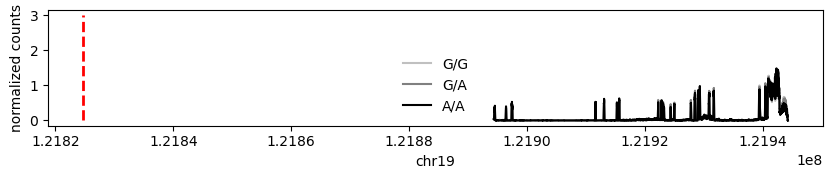

In [9]:

plot_gene('ENSG00000163406', 'Brain_Anterior_cingulate_cortex_BA24', 'chr3_121824730_A_C_b38', )

15976596
15976510


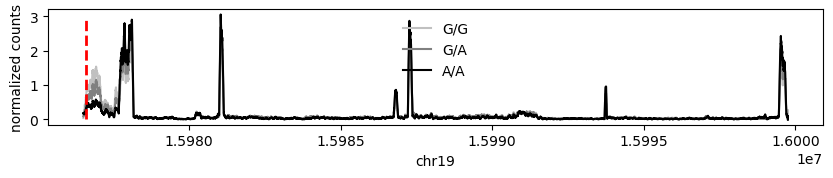

In [13]:
plot_gene('ENSG00000214941', 'Brain_Anterior_cingulate_cortex_BA24', 'chr17_15976596_C_T_b38')

In [19]:
15967894 - 16107606

-139712

In [157]:
import tabix

# chr8_11844613_alzheimer_disease # GCST004630	
tb_ = tabix.open('../code/GCST004627.for_visualization.bed.gz')

#chr12_54292096_GCST004630	2	Whole_Blood;ENSG00000135486.isoform_5,
#chr12_54292096_C_T_b38  chr6_130075400_GCST004627
records_ = tb_.query("chr6", 130075400-500000, 130075400+500000)

pos_list = []
pval_list = []
beta_list = []
se_list = []
var_list = []
for record in records_:

    pos = int(record[1])
    pval = float(record[3])
    # beta = float(record[6])
    # se = float(record[7])
    pos_list.append(pos)
    pval_list.append(pval)
    # beta_list.append(beta)
    # se_list.append(se)

    var =  record[4]#.split('_')#'chr' + record[4] + #.split(':')
    var = 'chr' + var + '_b38'
    # var = ['chr' + var[0], var[1], var[2], var[3]]

    # var_change = [x.upper() for x in var[2:]]

    # var = '_'.join([record[0], record[1], var[3], var[2]]) + '_b38'
    
    var_list.append(var)

In [158]:
ad_df = pd.DataFrame()
ad_df['pos'] = pos_list
ad_df['pval'] = pval_list
# ad_df['beta'] = beta_list
# ad_df['se'] = se_list
ad_df['var_id'] = var_list

In [159]:

tb_ = tabix.open('../code/QTLs/GTEx_10/Whole_Blood/transcripts_10.ForGWASColoc.NominalPass.txt.tabix.gz')
records_ = tb_.query("chr6", 130075400-500000, 130075400+500000)

pos_list = []
pval_list = []
beta_list = []
se_list = []
var_list = []
    
for record in records_:
    if ('ENSG00000198945.isoform_3' in record[0]) and ('chr6_130075400_N_N_GCST004627' in record[0]):
        pos = int(record[10])
        pval = float(record[11])
        beta = float(record[13])
        se = float(record[14])
        pos_list.append(pos)
        pval_list.append(pval)
        beta_list.append(beta)
        se_list.append(se)
        var_list.append(record[7])

In [160]:
brain_df = pd.DataFrame()
brain_df['pos'] = pos_list
brain_df['pval'] = pval_list
brain_df['beta'] = beta_list
brain_df['se'] = se_list
brain_df['var_id'] = var_list

In [161]:
merged_df = ad_df.merge(brain_df, left_on = 'var_id', right_on='var_id')#.drop_duplicates()

Text(0, 0.5, '-log10 pval ENSG00000213949 Intron Retention')

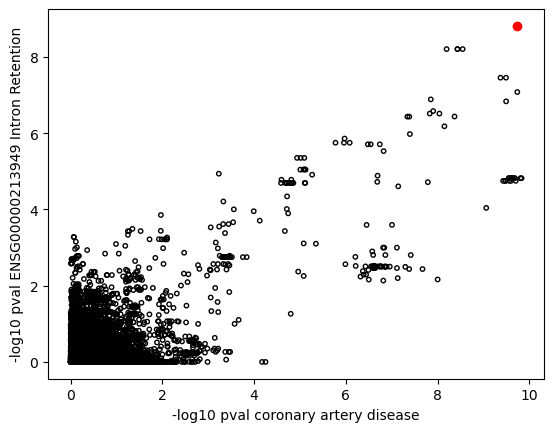

In [163]:
plt.scatter(np.array(-np.log10(merged_df.pval_x)), np.array(-np.log10(merged_df.pval_y)), facecolor='none', edgecolor='black', s=10)
plt.scatter(np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr6_130053316_T_A_b38'].pval_x)), 
            np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr6_130053316_T_A_b38'].pval_y)), c='red')

# plt.text(np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr5_52897294_A_G_b38'].pval_x)+0.5), 
            # np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr5_52897294_A_G_b38'].pval_y)-0.2), 'apaQTL', c='red')

# plt.scatter(np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr17_15976596_C_T_b38'].pval_x)), 
#             np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr17_15976596_C_T_b38'].pval_y)), c='purple')

# plt.text(np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr17_15976596_C_T_b38'].pval_x)-2), 
#             np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr17_15976596_C_T_b38'].pval_y)+0.5), 'rs12151021', c='purple')

plt.xlabel("-log10 pval coronary artery disease")
plt.ylabel('-log10 pval ENSG00000213949 Intron Retention')

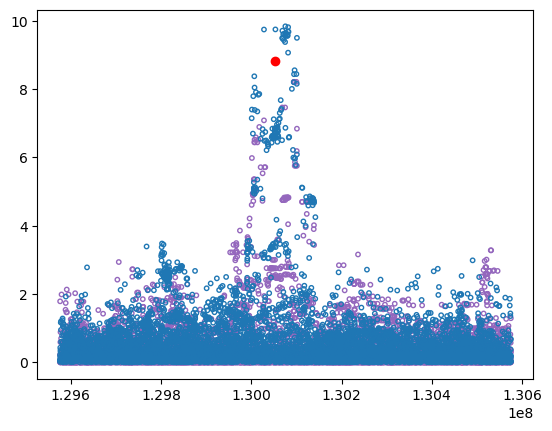

In [172]:
plt.scatter(merged_df.pos_x, np.array(-np.log10(merged_df.pval_y)), facecolor='none', edgecolor='tab:purple', s=10)

plt.scatter(merged_df.pos_x, np.array(-np.log10(merged_df.pval_x)), facecolor='none', edgecolor='tab:blue', s=10)



plt.scatter(np.array(merged_df.loc[merged_df.var_id == 'chr6_130053316_T_A_b38'].pos_x), 
            np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr6_130053316_T_A_b38'].pval_y)), c='red')

In [147]:
import tabix

# chr8_11844613_alzheimer_disease # GCST004630	
tb_ = tabix.open('../code/GCST004624.bed.gz')

#chr12_54292096_GCST004630	2	Whole_Blood;ENSG00000135486.isoform_5,
#chr12_54292096_C_T_b38
records_ = tb_.query("chr1", 22938567-500000, 22938567+500000)

pos_list = []
pval_list = []
beta_list = []
se_list = []
var_list = []
for record in records_:

    pos = int(record[1])
    pval = float(record[3])
    # beta = float(record[6])
    # se = float(record[7])
    pos_list.append(pos)
    pval_list.append(pval)
    # beta_list.append(beta)
    # se_list.append(se)

    var =  record[4]#.split('_')#'chr' + record[4] + #.split(':')
    var = 'chr' + var + '_b38'
    # var = ['chr' + var[0], var[1], var[2], var[3]]

    # var_change = [x.upper() for x in var[2:]]

    # var = '_'.join([record[0], record[1], var[3], var[2]]) + '_b38'
    
    var_list.append(var)

In [148]:
ad_df = pd.DataFrame()
ad_df['pos'] = pos_list
ad_df['pval'] = pval_list
# ad_df['beta'] = beta_list
# ad_df['se'] = se_list
ad_df['var_id'] = var_list

In [150]:

tb_ = tabix.open('../code/QTLs/GTEx_10/Skin_Not_Sun_Exposed_Suprapubic/transcripts_10.ForGWASColoc.NominalPass.txt.tabix.gz')
records_ = tb_.query("chr1", 22938567-500000, 22938567+500000)

pos_list = []
pval_list = []
beta_list = []
se_list = []
var_list = []
    
for record in records_:
    if ('ENSG00000204219.isoform_7' in record[0]) and ('chr1_22938567_N_N_GCST004624' in record[0]):
        pos = int(record[10])
        pval = float(record[11])
        beta = float(record[13])
        se = float(record[14])
        pos_list.append(pos)
        pval_list.append(pval)
        beta_list.append(beta)
        se_list.append(se)
        var_list.append(record[7])

In [151]:
brain_df = pd.DataFrame()
brain_df['pos'] = pos_list
brain_df['pval'] = pval_list
brain_df['beta'] = beta_list
brain_df['se'] = se_list
brain_df['var_id'] = var_list

In [152]:
merged_df = ad_df.merge(brain_df, left_on = 'var_id', right_on='var_id')#.drop_duplicates()

In [153]:
merged_df

,pos_x,pval_x,var_id,pos_y,pval_y,beta,se
0,22438731,0.50490,chr1_22438731_C_G_b38,22438731,0.507561,0.184774,0.277755
1,22439087,0.06305,chr1_22439087_C_T_b38,22439087,0.453992,0.411735,0.547546
2,22439113,0.54310,chr1_22439113_G_A_b38,22439113,0.723939,-0.139015,0.392385
3,22439488,0.64790,chr1_22439488_G_C_b38,22439488,0.507561,0.184774,0.277755
4,22439519,0.96480,chr1_22439519_C_T_b38,22439519,1.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
14540,23438407,0.46330,chr1_23438407_T_C_b38,23438407,0.282036,0.484842,0.448056
14541,23438470,0.55310,chr1_23438470_T_A_b38,23438470,0.419320,0.317403,0.391256
14542,23438470,0.55310,chr1_23438470_T_A_b38,23438470,0.419320,0.317403,0.391256
14543,23438470,0.55310,chr1_23438470_T_A_b38,23438470,0.419320,0.317403,0.391256


Text(0, 0.5, '-log10 pval ENSG00000213949 Intron Retention')

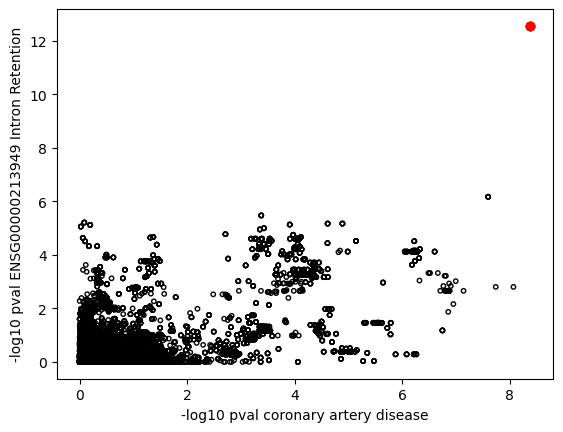

In [155]:
plt.scatter(np.array(-np.log10(merged_df.pval_x)), np.array(-np.log10(merged_df.pval_y)), facecolor='none', edgecolor='black', s=10)
plt.scatter(np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr1_23383982_C_T_b38'].pval_x)), 
            np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr1_23383982_C_T_b38'].pval_y)), c='red')

# plt.text(np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr5_52897294_A_G_b38'].pval_x)+0.5), 
            # np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr5_52897294_A_G_b38'].pval_y)-0.2), 'apaQTL', c='red')

# plt.scatter(np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr17_15976596_C_T_b38'].pval_x)), 
#             np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr17_15976596_C_T_b38'].pval_y)), c='purple')

# plt.text(np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr17_15976596_C_T_b38'].pval_x)-2), 
#             np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr17_15976596_C_T_b38'].pval_y)+0.5), 'rs12151021', c='purple')

plt.xlabel("-log10 pval coronary artery disease")
plt.ylabel('-log10 pval ENSG00000213949 Intron Retention')

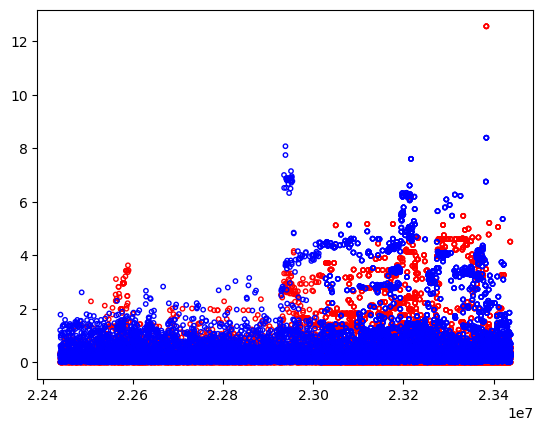

In [156]:
plt.scatter(merged_df.pos_x, np.array(-np.log10(merged_df.pval_y)), facecolor='none', edgecolor='red', s=10)

plt.scatter(merged_df.pos_x, np.array(-np.log10(merged_df.pval_x)), facecolor='none', edgecolor='blue', s=10)


In [122]:
import tabix

# chr8_11844613_alzheimer_disease # GCST004630	
tb_ = tabix.open('../code/parkinson_for_visualization.bed.gz')

#chr12_54292096_GCST004630	2	Whole_Blood;ENSG00000135486.isoform_5,
#chr12_54292096_C_T_b38
records_ = tb_.query("chr17", 16107606-2000000, 16107606+2000000)

pos_list = []
pval_list = []
beta_list = []
se_list = []
var_list = []
for record in records_:

    pos = int(record[1])
    pval = float(record[3])
    # beta = float(record[6])
    # se = float(record[7])
    pos_list.append(pos)
    pval_list.append(pval)
    # beta_list.append(beta)
    # se_list.append(se)

    var =  record[4].split(':')
    # var = ['chr' + var[0], var[1], var[2], var[3]]

    # var_change = [x.upper() for x in var[2:]]

    var = '_'.join([record[0], record[1], var[3], var[2]]) + '_b38'
    
    var_list.append(var)

In [123]:
ad_df = pd.DataFrame()
ad_df['pos'] = pos_list
ad_df['pval'] = pval_list
# ad_df['beta'] = beta_list
# ad_df['se'] = se_list
ad_df['var_id'] = var_list

In [124]:

tb_ = tabix.open('../code/QTLs/GTEx_10/Brain_Anterior_cingulate_cortex_BA24/transcripts_10.ForGWASColoc.NominalPass.txt.tabix.gz')
records_ = tb_.query("chr17", 16107606-2000000, 16107606+2000000)

pos_list = []
pval_list = []
beta_list = []
se_list = []
var_list = []
    
for record in records_:
    if ('ENSG00000214941.isoform_8' in record[0]) and ('chr17_16107606_N_N_parkinson_disease' in record[0]):
        pos = int(record[10])
        pval = float(record[11])
        beta = float(record[13])
        se = float(record[14])
        pos_list.append(pos)
        pval_list.append(pval)
        beta_list.append(beta)
        se_list.append(se)
        var_list.append(record[7])

In [125]:
brain_df = pd.DataFrame()
brain_df['pos'] = pos_list
brain_df['pval'] = pval_list
brain_df['beta'] = beta_list
brain_df['se'] = se_list
brain_df['var_id'] = var_list

In [126]:
merged_df = ad_df.merge(brain_df, left_on = 'var_id', right_on='var_id')#.drop_duplicates()

In [133]:
brain_df.loc[brain_df.var_id == 'chr17_15976596_C_T_b38']

,pos,pval,beta,se,var_id
10262,15976596,8.875870e-23,1.13049,0.084973,chr17_15976596_C_T_b38


In [134]:
merged_df.loc[merged_df.pos_x == 15976596]

,pos_x,pval_x,var_id,pos_y,pval_y,beta,se


In [115]:
ad_df.var_id.apply(lambda x: x.sub

SyntaxError: incomplete input (460676216.py, line 1)

In [139]:
merged_df.loc[683]

pos_x                   15980913
pval_x                       0.0
var_id    chr17_15980913_A_G_b38
pos_y                   15980913
pval_y                       0.0
beta                     1.11617
se                      0.089382
Name: 683, dtype: object

In [117]:
15967894 - 15976596

-8702

Text(0, 0.5, '-log10 pval ENSG00000213949 Intron Retention')

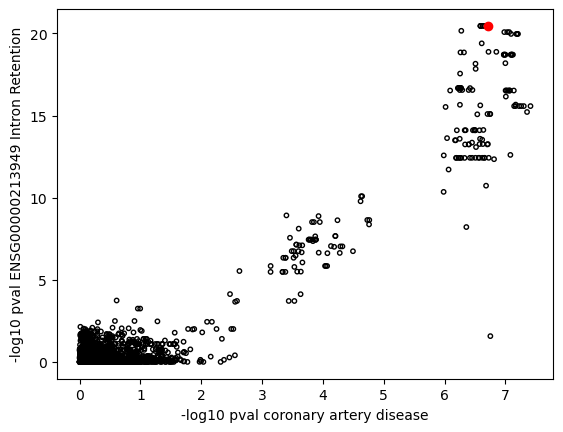

In [140]:
plt.scatter(np.array(-np.log10(merged_df.pval_x)), np.array(-np.log10(merged_df.pval_y)), facecolor='none', edgecolor='black', s=10)
plt.scatter(np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr17_15980913_A_G_b38'].pval_x)), 
            np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr17_15980913_A_G_b38'].pval_y)), c='red')

# plt.text(np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr5_52897294_A_G_b38'].pval_x)+0.5), 
            # np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr5_52897294_A_G_b38'].pval_y)-0.2), 'apaQTL', c='red')

# plt.scatter(np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr17_15976596_C_T_b38'].pval_x)), 
#             np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr17_15976596_C_T_b38'].pval_y)), c='purple')

# plt.text(np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr17_15976596_C_T_b38'].pval_x)-2), 
#             np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr17_15976596_C_T_b38'].pval_y)+0.5), 'rs12151021', c='purple')

plt.xlabel("-log10 pval coronary artery disease")
plt.ylabel('-log10 pval ENSG00000213949 Intron Retention')

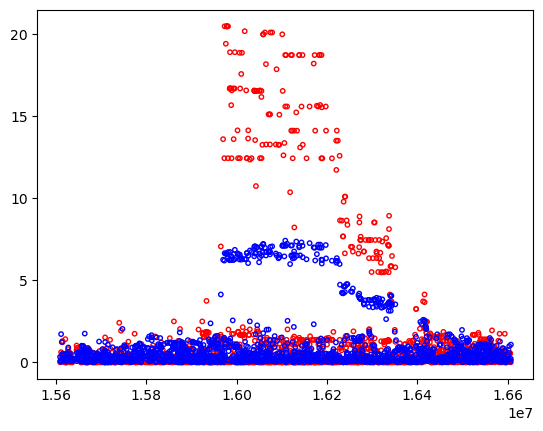

In [135]:
plt.scatter(merged_df.pos_x, np.array(-np.log10(merged_df.pval_y)), facecolor='none', edgecolor='red', s=10)

plt.scatter(merged_df.pos_x, np.array(-np.log10(merged_df.pval_x)), facecolor='none', edgecolor='blue', s=10)


In [16]:
counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000175221.csv.gz', index_col=0)
counts_ba9 = counts.loc[[x for x in counts.index if 'Whole_Blood' in x]]
counts_ba9.index = ['-'.join(x.split('-')[:2]) for x in counts_ba9.index]


var_id = 'chr19_871033_G_A_b38'
rec_ = get_snp_record(gtex_vcf, var_id)
ref = rec_.REF
alt = str(rec_.ALT[0])
hom_refs = pd.Index([x.sample for x in rec_.get_hom_refs()]).intersection(counts_ba9.index)
hets = pd.Index([x.sample for x in rec_.get_hets()]).intersection(counts_ba9.index)
hom_alts = pd.Index([x.sample for x in rec_.get_hom_alts()]).intersection(counts_ba9.index)

total_samples = hom_refs.union(hets).union(hom_alts)
samples_intersect = counts_ba9.index.intersection(total_samples)


rpkm_ba9 = 1e9*counts_ba9.divide(counts_ba9.sum(axis=1), axis=0)/counts_ba9.shape[1]

Text(0, 0.5, 'normalized counts')

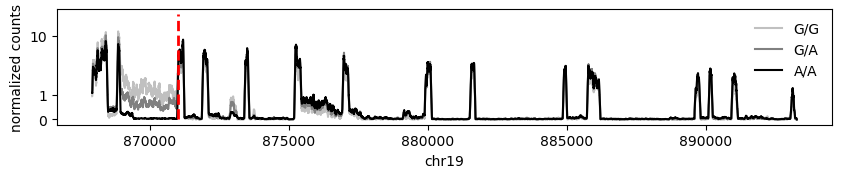

In [18]:
fig, ax = plt.subplots(figsize = (10, 1.5))

first_pos = 867934

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_alts)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+50]) for i in range(len(mean_counts))]
x = range(first_pos, first_pos+len(smoothed_mean))
ax.plot(x, smoothed_mean, c = 'silver', label = 'G/G')

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hets)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+50]) for i in range(len(mean_counts))]
ax.plot(x, smoothed_mean, c='gray', label='G/A')

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_refs)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+50]) for i in range(len(mean_counts))]
ax.plot(x, smoothed_mean, c='black', label = 'A/A')

var_loc = 871033
ax.plot([var_loc, var_loc], [0, 3], linestyle='--', c='red', linewidth=2)
ax.legend(frameon=False)
ax.set_xlabel('chr19')
ax.set_yticks([np.log1p(0), np.log1p(1), np.log1p(10)])
ax.set_yticklabels(['0', '1', '10'])
ax.set_ylabel('normalized counts')

In [108]:
ba24_qtls = pd.read_csv('../code/QTLs/GTEx_10/Brain_Anterior_cingulate_cortex_BA24/transcripts_10.GroupedPermutationPass.FDR_Added.txt.gz', sep=' ')


In [109]:
ba24_qtls.loc[ba24_qtls.grp_id == 'ENSG00000214941']

,grp_id,phe_chr,phe_from,phe_to,phe_strd,phe_id,n_phe_in_grp,n_var_in_cis,dist_phe_var,var_id,...,dof2,bml1,bml2,nom_pval,r_squared,slope,slope_se,adj_emp_pval,adj_beta_pval,q
9072,ENSG00000214941,chr17,15976511,15999753,-,ENSG00000214941.isoform_8,6,51154,0,chr17_15976596_C_T_b38,...,49.4484,1.17108,2167.81,8.875870e-23,0.667924,1.13049,0.084973,0.000999,9.948640e-12,4.997500e-10


In [22]:
counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000214941.csv.gz', index_col=0)
counts_ba9 = counts.loc[[x for x in counts.index if 'Brain_Anterior_cingulate_cortex_BA24' in x]]
counts_ba9.index = ['-'.join(x.split('-')[:2]) for x in counts_ba9.index]


var_id = 'chr17_15976596_C_T_b38'
rec_ = get_snp_record(gtex_vcf, var_id)
ref = rec_.REF
alt = str(rec_.ALT[0])
hom_refs = pd.Index([x.sample for x in rec_.get_hom_refs()]).intersection(counts_ba9.index)
hets = pd.Index([x.sample for x in rec_.get_hets()]).intersection(counts_ba9.index)
hom_alts = pd.Index([x.sample for x in rec_.get_hom_alts()]).intersection(counts_ba9.index)

total_samples = hom_refs.union(hets).union(hom_alts)
samples_intersect = counts_ba9.index.intersection(total_samples)


rpkm_ba9 = 1e9*counts_ba9.divide(counts_ba9.sum(axis=1), axis=0)/counts_ba9.shape[1]

In [23]:
counts.columns[0]

'chr17:15976510'

Text(0, 0.5, 'normalized counts')

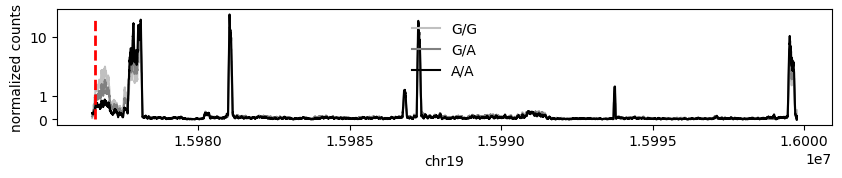

In [24]:
fig, ax = plt.subplots(figsize = (10, 1.5))

first_pos = 15976510

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_alts)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+50]) for i in range(len(mean_counts))]
x = range(first_pos, first_pos+len(smoothed_mean))
ax.plot(x, smoothed_mean, c = 'silver', label = 'G/G')

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hets)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+50]) for i in range(len(mean_counts))]
ax.plot(x, smoothed_mean, c='gray', label='G/A')

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_refs)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+50]) for i in range(len(mean_counts))]
ax.plot(x, smoothed_mean, c='black', label = 'A/A')

var_loc = 15976596
ax.plot([var_loc, var_loc], [0, 3], linestyle='--', c='red', linewidth=2)
ax.legend(frameon=False)
ax.set_xlabel('chr19')
ax.set_yticks([np.log1p(0), np.log1p(1), np.log1p(10)])
ax.set_yticklabels(['0', '1', '10'])
ax.set_ylabel('normalized counts')

In [25]:
bc_qtls = pd.read_csv('../code/QTLs/GTEx_10/Brain_Cortex/transcripts_10.GroupedPermutationPass.FDR_Added.txt.gz', sep=' ')


In [27]:
ba24_qtls.loc[ba24_qtls.grp_id == 'ENSG00000137845']

,grp_id,phe_chr,phe_from,phe_to,phe_strd,phe_id,n_phe_in_grp,n_var_in_cis,dist_phe_var,var_id,...,dof2,bml1,bml2,nom_pval,r_squared,slope,slope_se,adj_emp_pval,adj_beta_pval,q
8721,ENSG00000137845,chr15,58588760,58749756,-,ENSG00000137845.isoform_4,5,56164,-195103,chr15_58944859_T_A_b38,...,57.4578,1.10113,6736.34,0.000001,0.236358,-1.7037,0.326447,0.539461,0.401918,0.70946


In [28]:
counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000137845.csv.gz', index_col=0)
counts_ba9 = counts.loc[[x for x in counts.index if 'Brain_Anterior_cingulate_cortex_BA24' in x]]
counts_ba9.index = ['-'.join(x.split('-')[:2]) for x in counts_ba9.index]


var_id = 'chr15_58753575_A_G_b38'
rec_ = get_snp_record(gtex_vcf, var_id)
ref = rec_.REF
alt = str(rec_.ALT[0])
hom_refs = pd.Index([x.sample for x in rec_.get_hom_refs()]).intersection(counts_ba9.index)
hets = pd.Index([x.sample for x in rec_.get_hets()]).intersection(counts_ba9.index)
hom_alts = pd.Index([x.sample for x in rec_.get_hom_alts()]).intersection(counts_ba9.index)

total_samples = hom_refs.union(hets).union(hom_alts)
samples_intersect = counts_ba9.index.intersection(total_samples)


rpkm_ba9 = 1e9*counts_ba9.divide(counts_ba9.sum(axis=1), axis=0)/counts_ba9.shape[1]

In [29]:
counts.columns[0]

'chr15:58588759'

Text(0, 0.5, 'normalized counts')

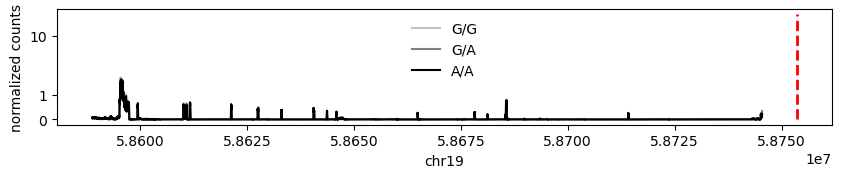

In [30]:
fig, ax = plt.subplots(figsize = (10, 1.5))

first_pos = 58588759

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_alts)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+50]) for i in range(len(mean_counts))]
x = range(first_pos, first_pos+len(smoothed_mean))
ax.plot(x, smoothed_mean, c = 'silver', label = 'G/G')

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hets)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+50]) for i in range(len(mean_counts))]
ax.plot(x, smoothed_mean, c='gray', label='G/A')

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_refs)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+50]) for i in range(len(mean_counts))]
ax.plot(x, smoothed_mean, c='black', label = 'A/A')

var_loc = 58753575
ax.plot([var_loc, var_loc], [0, 3], linestyle='--', c='red', linewidth=2)
ax.legend(frameon=False)
ax.set_xlabel('chr19')
ax.set_yticks([np.log1p(0), np.log1p(1), np.log1p(10)])
ax.set_yticklabels(['0', '1', '10'])
ax.set_ylabel('normalized counts')

In [31]:
ba24_qtls.loc[ba24_qtls.grp_id == 'ENSG00000100034']

,grp_id,phe_chr,phe_from,phe_to,phe_strd,phe_id,n_phe_in_grp,n_var_in_cis,dist_phe_var,var_id,...,dof2,bml1,bml2,nom_pval,r_squared,slope,slope_se,adj_emp_pval,adj_beta_pval,q
1368,ENSG00000100034,chr22,21919376,21941051,-,ENSG00000100034.isoform_3,2,57651,0,chr22_21938623_C_A_b38,...,86.4703,0.954778,11435.6,2.269370e-13,0.458911,-0.62774,0.072662,0.000999,1.020360e-08,3.049600e-07


In [32]:
counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000100034.csv.gz', index_col=0)
counts_ba9 = counts.loc[[x for x in counts.index if 'Brain_Anterior_cingulate_cortex_BA24' in x]]
counts_ba9.index = ['-'.join(x.split('-')[:2]) for x in counts_ba9.index]


var_id = 'chr22_21938623_C_A_b38'
rec_ = get_snp_record(gtex_vcf, var_id)
ref = rec_.REF
alt = str(rec_.ALT[0])
hom_refs = pd.Index([x.sample for x in rec_.get_hom_refs()]).intersection(counts_ba9.index)
hets = pd.Index([x.sample for x in rec_.get_hets()]).intersection(counts_ba9.index)
hom_alts = pd.Index([x.sample for x in rec_.get_hom_alts()]).intersection(counts_ba9.index)

total_samples = hom_refs.union(hets).union(hom_alts)
samples_intersect = counts_ba9.index.intersection(total_samples)


rpkm_ba9 = 1e9*counts_ba9.divide(counts_ba9.sum(axis=1), axis=0)/counts_ba9.shape[1]

In [33]:
counts.columns[0]

'chr22:21919375'

Text(0, 0.5, 'normalized counts')

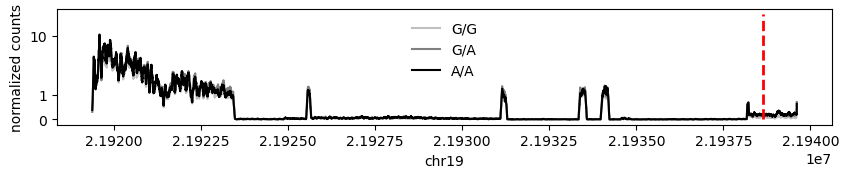

In [34]:
fig, ax = plt.subplots(figsize = (10, 1.5))

first_pos = 21919375

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_alts)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+50]) for i in range(len(mean_counts))]
x = range(first_pos, first_pos+len(smoothed_mean))
ax.plot(x, smoothed_mean, c = 'silver', label = 'G/G')

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hets)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+50]) for i in range(len(mean_counts))]
ax.plot(x, smoothed_mean, c='gray', label='G/A')

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_refs)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+50]) for i in range(len(mean_counts))]
ax.plot(x, smoothed_mean, c='black', label = 'A/A')

var_loc = 21938623
ax.plot([var_loc, var_loc], [0, 3], linestyle='--', c='red', linewidth=2)
ax.legend(frameon=False)
ax.set_xlabel('chr19')
ax.set_yticks([np.log1p(0), np.log1p(1), np.log1p(10)])
ax.set_yticklabels(['0', '1', '10'])
ax.set_ylabel('normalized counts')

In [36]:
ba24_qtls.loc[ba24_qtls.grp_id == 'ENSG00000090975']

,grp_id,phe_chr,phe_from,phe_to,phe_strd,phe_id,n_phe_in_grp,n_var_in_cis,dist_phe_var,var_id,...,dof2,bml1,bml2,nom_pval,r_squared,slope,slope_se,adj_emp_pval,adj_beta_pval,q
5377,ENSG00000090975,chr12,122983431,123151139,-,ENSG00000090975.isoform_7,4,53297,-1155,chr12_123152294_A_G_b38,...,94.4109,0.940615,76879.5,1.531960e-14,0.490694,-0.589519,0.064024,0.000999,5.178810e-10,1.919300e-08


In [37]:
counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000090975.csv.gz', index_col=0)
counts_ba9 = counts.loc[[x for x in counts.index if 'Brain_Anterior_cingulate_cortex_BA24' in x]]
counts_ba9.index = ['-'.join(x.split('-')[:2]) for x in counts_ba9.index]


var_id = 'chr12_123135291_G_A_b38'
rec_ = get_snp_record(gtex_vcf, var_id)
ref = rec_.REF
alt = str(rec_.ALT[0])
hom_refs = pd.Index([x.sample for x in rec_.get_hom_refs()]).intersection(counts_ba9.index)
hets = pd.Index([x.sample for x in rec_.get_hets()]).intersection(counts_ba9.index)
hom_alts = pd.Index([x.sample for x in rec_.get_hom_alts()]).intersection(counts_ba9.index)

total_samples = hom_refs.union(hets).union(hom_alts)
samples_intersect = counts_ba9.index.intersection(total_samples)


rpkm_ba9 = 1e9*counts_ba9.divide(counts_ba9.sum(axis=1), axis=0)/counts_ba9.shape[1]

In [38]:
counts.columns[0]

'chr12:122983430'

Text(0, 0.5, 'normalized counts')

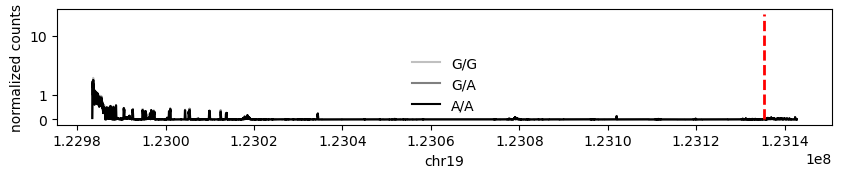

In [40]:
fig, ax = plt.subplots(figsize = (10, 1.5))

first_pos = 122983430

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_alts)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+50]) for i in range(len(mean_counts))]
x = range(first_pos, first_pos+len(smoothed_mean))
ax.plot(x, smoothed_mean, c = 'silver', label = 'G/G')

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hets)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+50]) for i in range(len(mean_counts))]
ax.plot(x, smoothed_mean, c='gray', label='G/A')

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_refs)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+50]) for i in range(len(mean_counts))]
ax.plot(x, smoothed_mean, c='black', label = 'A/A')

var_loc = 123135291
ax.plot([var_loc, var_loc], [0, 3], linestyle='--', c='red', linewidth=2)
ax.legend(frameon=False)
ax.set_xlabel('chr19')
ax.set_yticks([np.log1p(0), np.log1p(1), np.log1p(10)])
ax.set_yticklabels(['0', '1', '10'])
ax.set_ylabel('normalized counts')

In [52]:
bc_qtls.loc[ba24_qtls.grp_id == 'ENSG00000198064']

,grp_id,phe_chr,phe_from,phe_to,phe_strd,phe_id,n_phe_in_grp,n_var_in_cis,dist_phe_var,var_id,...,dof2,bml1,bml2,nom_pval,r_squared,slope,slope_se,adj_emp_pval,adj_beta_pval,q
3395,ENSG00000198064,chr16,30222848,30248528,-,ENSG00000198064.isoform_4,5,44360,-63961,chr16_30312489_C_T_b38,...,78.4125,1.07402,40617.4,7.668390e-10,0.371368,-0.485428,0.069745,0.000999,0.000035,0.000524


In [168]:
counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000172890.csv.gz', index_col=0)
counts_ba9 = counts.loc[[x for x in counts.index if 'Brain_Anterior_cingulate_cortex_BA24' in x]]
counts_ba9.index = ['-'.join(x.split('-')[:2]) for x in counts_ba9.index]


var_id = 'chr11_71439739_A_C_b38'
rec_ = get_snp_record(gtex_vcf, var_id)
ref = rec_.REF
alt = str(rec_.ALT[0])
hom_refs = pd.Index([x.sample for x in rec_.get_hom_refs()]).intersection(counts_ba9.index)
hets = pd.Index([x.sample for x in rec_.get_hets()]).intersection(counts_ba9.index)
hom_alts = pd.Index([x.sample for x in rec_.get_hom_alts()]).intersection(counts_ba9.index)

total_samples = hom_refs.union(hets).union(hom_alts)
samples_intersect = counts_ba9.index.intersection(total_samples)


rpkm_ba9 = 1e9*counts_ba9.divide(counts_ba9.sum(axis=1), axis=0)/counts_ba9.shape[1]

In [169]:
counts.columns[0]

'chr11:71453153'

Text(0, 0.5, 'normalized counts')

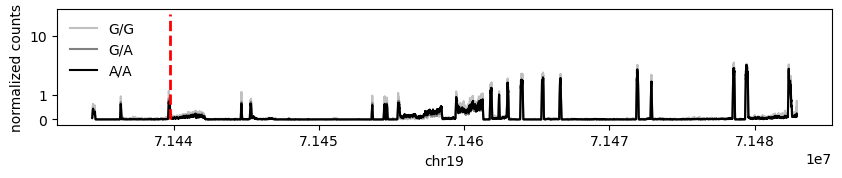

In [170]:
fig, ax = plt.subplots(figsize = (10, 1.5))

first_pos = 71434361

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_alts)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+50]) for i in range(len(mean_counts))]
x = range(first_pos, first_pos+len(smoothed_mean))
ax.plot(x, smoothed_mean, c = 'silver', label = 'G/G')

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hets)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+50]) for i in range(len(mean_counts))]
ax.plot(x, smoothed_mean, c='gray', label='G/A')

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_refs)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+50]) for i in range(len(mean_counts))]
ax.plot(x, smoothed_mean, c='black', label = 'A/A')

var_loc = 71439739
ax.plot([var_loc, var_loc], [0, 3], linestyle='--', c='red', linewidth=2)
ax.legend(frameon=False)
ax.set_xlabel('chr19')
ax.set_yticks([np.log1p(0), np.log1p(1), np.log1p(10)])
ax.set_yticklabels(['0', '1', '10'])
ax.set_ylabel('normalized counts')

In [53]:
ba9_qtls = bc_qtls = pd.read_csv('../code/QTLs/GTEx_10/Brain_Frontal_Cortex_BA9/transcripts_10.GroupedPermutationPass.FDR_Added.txt.gz', sep=' ')


In [122]:
counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000119242.csv.gz', index_col=0)
counts_ba9 = counts.loc[[x for x in counts.index if 'Heart_Atrial_Appendage' in x]]
counts_ba9.index = ['-'.join(x.split('-')[:2]) for x in counts_ba9.index]


var_id = 'chr12_123940602_C_T_b38'
rec_ = get_snp_record(gtex_vcf, var_id)
ref = rec_.REF
alt = str(rec_.ALT[0])
hom_refs = pd.Index([x.sample for x in rec_.get_hom_refs()]).intersection(counts_ba9.index)
hets = pd.Index([x.sample for x in rec_.get_hets()]).intersection(counts_ba9.index)
hom_alts = pd.Index([x.sample for x in rec_.get_hom_alts()]).intersection(counts_ba9.index)

total_samples = hom_refs.union(hets).union(hom_alts)
samples_intersect = counts_ba9.index.intersection(total_samples)


rpkm_ba9 = 1e9*counts_ba9.divide(counts_ba9.sum(axis=1), axis=0)/counts_ba9.shape[1]

In [123]:
counts.columns[0]

'chr12:123936367'

Text(0, 0.5, 'normalized counts')

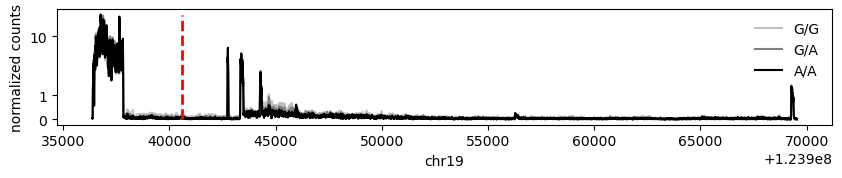

In [124]:
fig, ax = plt.subplots(figsize = (10, 1.5))

first_pos = 123936367

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_alts)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+20]) for i in range(len(mean_counts))]
x = range(first_pos, first_pos+len(smoothed_mean))
ax.plot(x, smoothed_mean, c = 'silver', label = 'G/G')

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hets)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+20]) for i in range(len(mean_counts))]
ax.plot(x, smoothed_mean, c='gray', label='G/A')

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_refs)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+20]) for i in range(len(mean_counts))]
ax.plot(x, smoothed_mean, c='black', label = 'A/A')

var_loc = 123940602
ax.plot([var_loc, var_loc], [0, 3], linestyle='--', c='red', linewidth=2)
ax.legend(frameon=False)
ax.set_xlabel('chr19')
ax.set_yticks([np.log1p(0), np.log1p(1), np.log1p(10)])
ax.set_yticklabels(['0', '1', '10'])
ax.set_ylabel('normalized counts')
# ax.set_xlim()

In [117]:
counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000140988.csv.gz', index_col=0)
counts_ba9 = counts.loc[[x for x in counts.index if 'Heart_Atrial_Appendage' in x]]
counts_ba9.index = ['-'.join(x.split('-')[:2]) for x in counts_ba9.index]


var_id = 'chr16_1964282_A_G_b38'
rec_ = get_snp_record(gtex_vcf, var_id)
ref = rec_.REF
alt = str(rec_.ALT[0])
hom_refs = pd.Index([x.sample for x in rec_.get_hom_refs()]).intersection(counts_ba9.index)
hets = pd.Index([x.sample for x in rec_.get_hets()]).intersection(counts_ba9.index)
hom_alts = pd.Index([x.sample for x in rec_.get_hom_alts()]).intersection(counts_ba9.index)

total_samples = hom_refs.union(hets).union(hom_alts)
samples_intersect = counts_ba9.index.intersection(total_samples)


rpkm_ba9 = 1e9*counts_ba9.divide(counts_ba9.sum(axis=1), axis=0)/counts_ba9.shape[1]

In [118]:
counts.columns[0]

'chr16:1962008'

Text(0, 0.5, 'normalized counts')

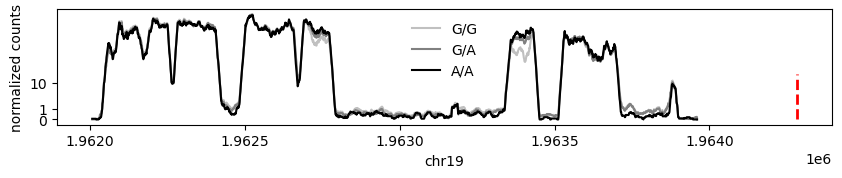

In [119]:
fig, ax = plt.subplots(figsize = (10, 1.5))

first_pos = 1962008

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_alts)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+20]) for i in range(len(mean_counts))]
x = range(first_pos, first_pos+len(smoothed_mean))
ax.plot(x, smoothed_mean, c = 'silver', label = 'G/G')

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hets)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+20]) for i in range(len(mean_counts))]
ax.plot(x, smoothed_mean, c='gray', label='G/A')

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_refs)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+20]) for i in range(len(mean_counts))]
ax.plot(x, smoothed_mean, c='black', label = 'A/A')

var_loc = 1964282
ax.plot([var_loc, var_loc], [0, 3], linestyle='--', c='red', linewidth=2)
ax.legend(frameon=False)
ax.set_xlabel('chr19')
ax.set_yticks([np.log1p(0), np.log1p(1), np.log1p(10)])
ax.set_yticklabels(['0', '1', '10'])
ax.set_ylabel('normalized counts')
# ax.set_xlim()

In [62]:
ba24_qtls.loc[ba24_qtls.q <= 0.01]

,grp_id,phe_chr,phe_from,phe_to,phe_strd,phe_id,n_phe_in_grp,n_var_in_cis,dist_phe_var,var_id,...,dof2,bml1,bml2,nom_pval,r_squared,slope,slope_se,adj_emp_pval,adj_beta_pval,q
7,ENSG00000162571,chr1,1176447,1197985,+,ENSG00000162571.isoform_2,1,57503,-131950,chr1_1044497_G_T_b38,...,141.9000,0.999942,6.469540e+31,2.398400e-25,0.709493,-2.286630,0.155977,0.221778,4.175900e-08,1.105400e-06
17,ENSG00000162576,chr1,1352642,1358604,-,ENSG00000162576.isoform_5,7,59948,116922,chr1_1235720_T_G_b38,...,59.5203,1.285090,1.667830e+04,1.025600e-12,0.440292,-1.048610,0.126032,0.000999,4.708640e-06,8.764200e-05
29,ENSG00000189339,chr1,1661429,1692844,-,ENSG00000189339.isoform_2,3,72448,0,chr1_1668717_C_G_b38,...,188.9770,1.000010,2.415900e+11,1.510930e-18,0.586214,-1.576060,0.141153,0.000999,1.122210e-26,4.068600e-24
44,ENSG00000130764,chr1,3778510,3796547,-,ENSG00000130764.isoform_1,3,59210,0,chr1_3779653_A_G_b38,...,41.6281,1.079040,1.512210e+03,4.016040e-14,0.479546,-1.038800,0.115363,0.000999,1.676920e-04,2.266300e-03
48,ENSG00000131697,chr1,5862762,5992211,-,ENSG00000131697.isoform_7,8,56453,0,chr1_5875102_T_A_b38,...,59.2797,0.926417,5.040780e+03,4.519180e-31,0.784460,1.589360,0.088809,0.000999,1.885780e-16,2.154100e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9299,ENSG00000149809,chr11,65111913,65116279,+,ENSG00000149809.isoform_5,5,45698,-14124,chr11_65097789_C_G_b38,...,66.0172,1.303860,6.878450e+03,8.557880e-09,0.315259,-0.822894,0.129280,0.000999,7.071410e-04,8.224000e-03
9306,ENSG00000166441,chr11,8682743,8689921,+,ENSG00000166441.isoform_2,2,50366,0,chr11_8687952_CTT_C_b38,...,72.5484,1.019430,3.865940e+03,7.054240e-09,0.318192,0.678099,0.105813,0.000999,4.941630e-04,5.946100e-03
9309,ENSG00000175348,chr11,8947153,8964491,-,ENSG00000175348.isoform_2,2,48848,34847,chr11_8912306_T_G_b38,...,77.5500,0.995420,4.456290e+03,7.689270e-34,0.813463,-1.650240,0.084240,0.000999,3.093510e-26,9.921500e-24
9329,ENSG00000148925,chr11,13387959,13463271,-,ENSG00000148925.isoform_4,1,44810,606008,chr11_12781951_C_CAA_b38,...,291.7920,1.000020,4.879880e+18,8.884600e-08,0.278797,-0.421568,0.072279,0.226773,8.354550e-04,9.569500e-03


In [63]:
counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000087088.csv.gz', index_col=0)
counts_ba9 = counts.loc[[x for x in counts.index if 'Whole_Blood' in x]]
counts_ba9.index = ['-'.join(x.split('-')[:2]) for x in counts_ba9.index]


var_id = 'chr19_48955847_A_G_b38'
rec_ = get_snp_record(gtex_vcf, var_id)
ref = rec_.REF
alt = str(rec_.ALT[0])
hom_refs = pd.Index([x.sample for x in rec_.get_hom_refs()]).intersection(counts_ba9.index)
hets = pd.Index([x.sample for x in rec_.get_hets()]).intersection(counts_ba9.index)
hom_alts = pd.Index([x.sample for x in rec_.get_hom_alts()]).intersection(counts_ba9.index)

total_samples = hom_refs.union(hets).union(hom_alts)
samples_intersect = counts_ba9.index.intersection(total_samples)


rpkm_ba9 = 1e9*counts_ba9.divide(counts_ba9.sum(axis=1), axis=0)/counts_ba9.shape[1]

In [64]:
counts.columns[0]

'chr19:48954825'

Text(0, 0.5, 'normalized counts')

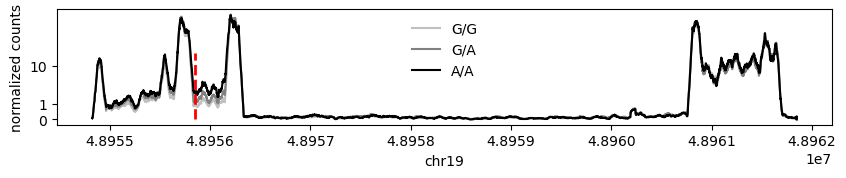

In [65]:
fig, ax = plt.subplots(figsize = (10, 1.5))

first_pos = 48954825

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_alts)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+50]) for i in range(len(mean_counts))]
x = range(first_pos, first_pos+len(smoothed_mean))
ax.plot(x, smoothed_mean, c = 'silver', label = 'G/G')

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hets)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+50]) for i in range(len(mean_counts))]
ax.plot(x, smoothed_mean, c='gray', label='G/A')

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_refs)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+50]) for i in range(len(mean_counts))]
ax.plot(x, smoothed_mean, c='black', label = 'A/A')

var_loc = 48955847
ax.plot([var_loc, var_loc], [0, 3], linestyle='--', c='red', linewidth=2)
ax.legend(frameon=False)
ax.set_xlabel('chr19')
ax.set_yticks([np.log1p(0), np.log1p(1), np.log1p(10)])
ax.set_yticklabels(['0', '1', '10'])
ax.set_ylabel('normalized counts')

In [114]:

counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000133103.csv.gz', index_col=0)
counts_ba9 = counts.loc[[x for x in counts.index if 'Skin_Not_Sun_Exposed_Suprapubic' in x]]
counts_ba9.index = ['-'.join(x.split('-')[:2]) for x in counts_ba9.index]


var_id = 'chr13_39776957_T_G_b38'
rec_ = get_snp_record(gtex_vcf, var_id)
ref = rec_.REF
alt = str(rec_.ALT[0])
hom_refs = pd.Index([x.sample for x in rec_.get_hom_refs()]).intersection(counts_ba9.index)
hets = pd.Index([x.sample for x in rec_.get_hets()]).intersection(counts_ba9.index)
hom_alts = pd.Index([x.sample for x in rec_.get_hom_alts()]).intersection(counts_ba9.index)

total_samples = hom_refs.union(hets).union(hom_alts)
samples_intersect = counts_ba9.index.intersection(total_samples)


rpkm_ba9 = 1e9*counts_ba9.divide(counts_ba9.sum(axis=1), axis=0)/counts_ba9.shape[1]

In [115]:
counts.columns[0]

'chr13:39655612'

/tmp/jobs/41597558/ipykernel_24629/1003118464.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0', '1', '10'])


Text(0, 0.5, 'normalized counts')

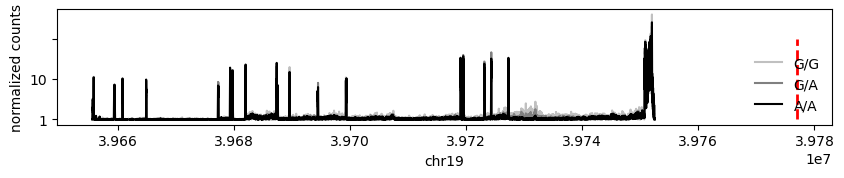

In [116]:
fig, ax = plt.subplots(figsize = (10, 1.5))

first_pos = 39655612

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_alts)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+20]) for i in range(len(mean_counts))]
x = range(first_pos, first_pos+len(smoothed_mean))
ax.plot(x, smoothed_mean, c = 'silver', label = 'G/G')

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hets)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+20]) for i in range(len(mean_counts))]
ax.plot(x, smoothed_mean, c='gray', label='G/A')

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_refs)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+20]) for i in range(len(mean_counts))]
ax.plot(x, smoothed_mean, c='black', label = 'A/A')

var_loc = 39776957
ax.plot([var_loc, var_loc], [0, 1], linestyle='--', c='red', linewidth=2)
ax.legend(frameon=False)
ax.set_xlabel('chr19')
# ax.set_yticks([np.log1p(0), np.log1p(1), np.log1p(10)])
ax.set_yticklabels(['0', '1', '10'])
ax.set_ylabel('normalized counts')

# ax.set_xlim([23380859, 23385082])

In [81]:

counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000197728.csv.gz', index_col=0)
counts_ba9 = counts.loc[[x for x in counts.index if 'Skin_Not_Sun_Exposed_Suprapubic' in x]]
counts_ba9.index = ['-'.join(x.split('-')[:2]) for x in counts_ba9.index]


var_id = 'chr12_56076841_C_T_b38'
rec_ = get_snp_record(gtex_vcf, var_id)
ref = rec_.REF
alt = str(rec_.ALT[0])
hom_refs = pd.Index([x.sample for x in rec_.get_hom_refs()]).intersection(counts_ba9.index)
hets = pd.Index([x.sample for x in rec_.get_hets()]).intersection(counts_ba9.index)
hom_alts = pd.Index([x.sample for x in rec_.get_hom_alts()]).intersection(counts_ba9.index)

total_samples = hom_refs.union(hets).union(hom_alts)
samples_intersect = counts_ba9.index.intersection(total_samples)


rpkm_ba9 = 1e9*counts_ba9.divide(counts_ba9.sum(axis=1), axis=0)/counts_ba9.shape[1]

In [82]:
counts.columns[0]

'chr12:56041301'

Text(0, 0.5, 'normalized counts')

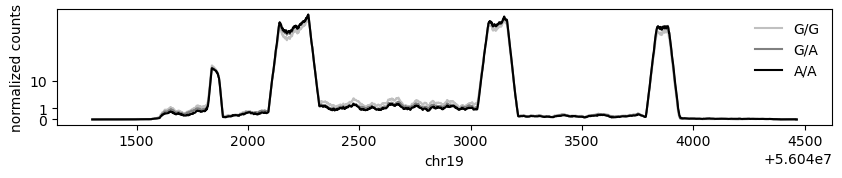

In [85]:
fig, ax = plt.subplots(figsize = (10, 1.5))

first_pos = 56041301

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_alts)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+50]) for i in range(len(mean_counts))]
x = range(first_pos, first_pos+len(smoothed_mean))
ax.plot(x, smoothed_mean, c = 'silver', label = 'G/G')

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hets)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+50]) for i in range(len(mean_counts))]
ax.plot(x, smoothed_mean, c='gray', label='G/A')

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_refs)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+50]) for i in range(len(mean_counts))]
ax.plot(x, smoothed_mean, c='black', label = 'A/A')

var_loc = 56076841
# ax.plot([var_loc, var_loc], [0, 3], linestyle='--', c='red', linewidth=2)
ax.legend(frameon=False)
ax.set_xlabel('chr19')
ax.set_yticks([np.log1p(0), np.log1p(1), np.log1p(10)])
ax.set_yticklabels(['0', '1', '10'])
ax.set_ylabel('normalized counts')

# ax.set_xlim([142130000, 142160000])

ENSG00000164535
6416460
6409079


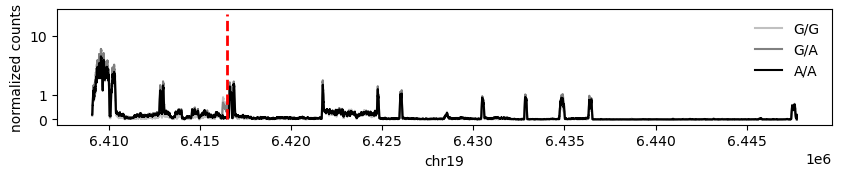

In [137]:
plot_gene('ENSG00000164535', 'Whole_Blood', 'chr7_6416460_C_T_b38')

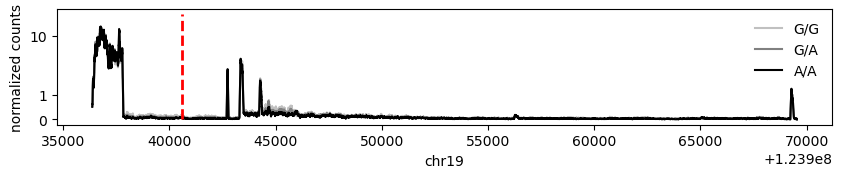

In [130]:
plot_gene('ENSG00000119242', 'Heart_Atrial_Appendage', 'chr12_123940602_C_T_b38')

66557112
66563414


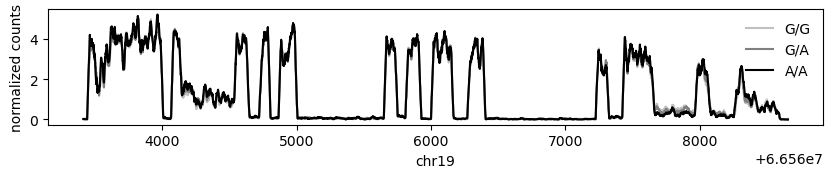

In [141]:
plot_gene('ENSG00000174080', 'Brain_Anterior_cingulate_cortex_BA24', 'chr11_66557112_T_C_b38', plot_var=False, smooth=20)

40860798
40857098


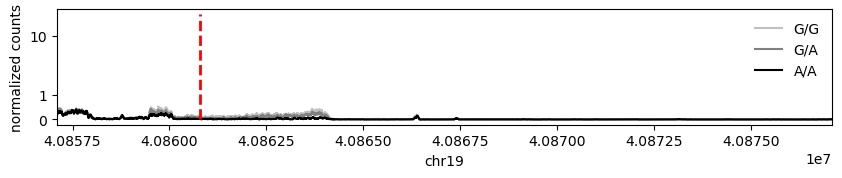

In [167]:
plot_gene('ENSG00000196236', 'Brain_Anterior_cingulate_cortex_BA24', 'chr22_40860798_A_G_b38', xlim = 20000)

71439739
71453153


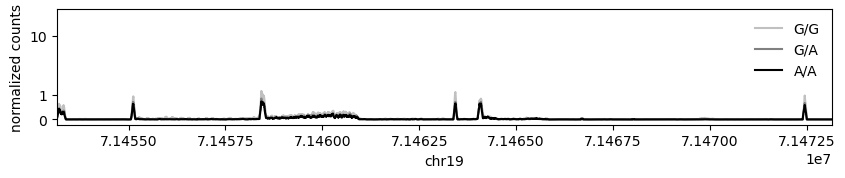

In [171]:
plot_gene('ENSG00000172890', 'Brain_Anterior_cingulate_cortex_BA24', 'chr11_71439739_A_C_b38', xlim = 20000)

In [180]:
plot_gene('ENSG00000120071', 'Brain_Anterior_cingulate_cortex_BA24', 'chr17_46274212_T_C_b38')


KeyboardInterrupt



21938623
21919225


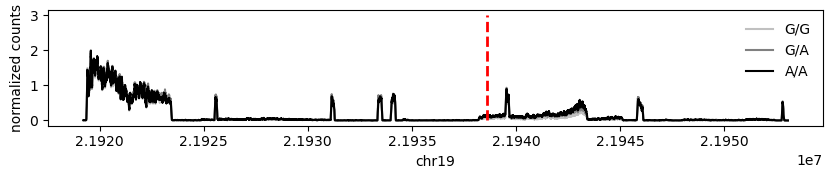

In [183]:

plot_gene('ENSG00000100034', 'Brain_Anterior_cingulate_cortex_BA24', 'chr22_21938623_C_A_b38', counts = 'whole_gene')

121824730
121894351


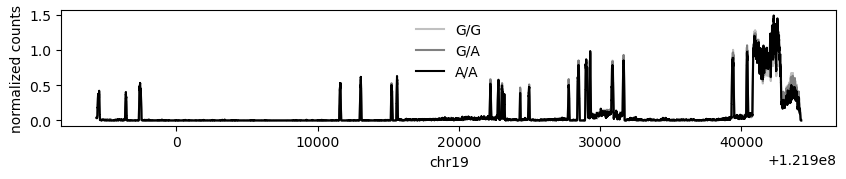

In [187]:

plot_gene('ENSG00000163406', 'Brain_Anterior_cingulate_cortex_BA24', 'chr3_121824730_A_C_b38', plot_var=False)

121919266
121894351


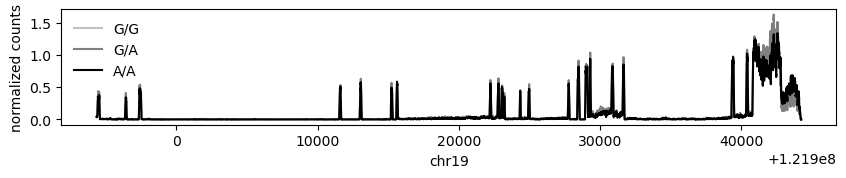

In [204]:

plot_gene('ENSG00000163406', 'Brain_Anterior_cingulate_cortex_BA24', 'chr3_121919266_G_C_b38', plot_var=False)

41191552
41092616


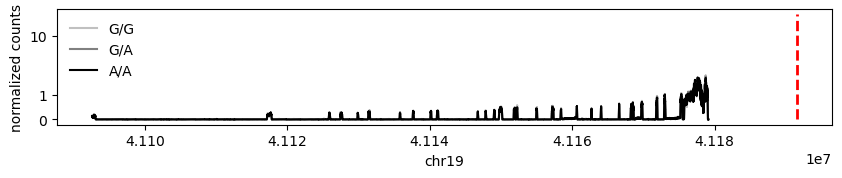

In [177]:

plot_gene('ENSG00000100393', 'Brain_Cortex', 'chr22_41191552_T_A_b38')

1964282
1961858


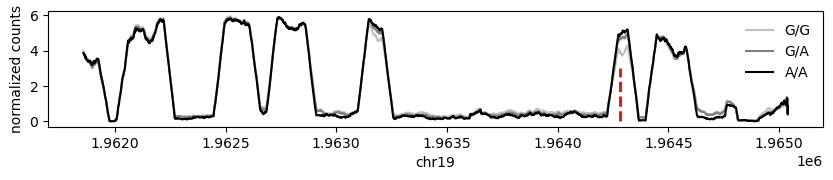

In [184]:

plot_gene('ENSG00000140988', 'Heart_Atrial_Appendage', 'chr16_1964282_A_G_b38', counts = 'whole_gene')

1964282
1962008


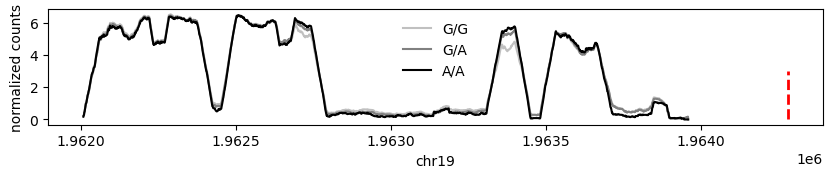

In [185]:
plot_gene('ENSG00000140988', 'Heart_Atrial_Appendage', 'chr16_1964282_A_G_b38', )

142130032
142108729


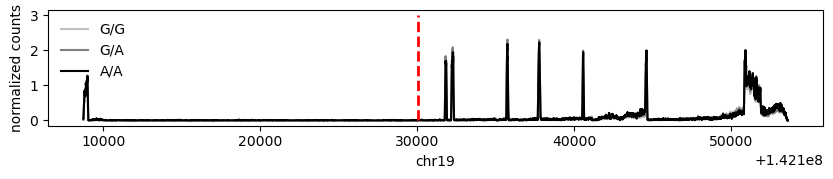

In [205]:
plot_gene('ENSG00000131507', 'Whole_Blood', 'chr5_142130032_G_A_b38', )

23383982
23380859


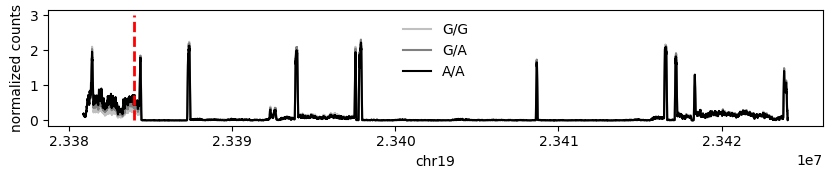

In [208]:

plot_gene('ENSG00000204219', 'Skin_Not_Sun_Exposed_Suprapubic', 'chr1_23383982_C_T_b38', )

54292096
54280143


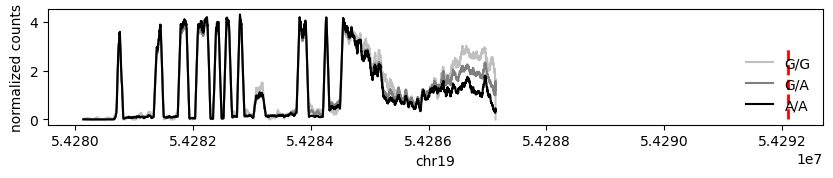

In [254]:
plot_gene('ENSG00000135486', 'Whole_Blood', 'chr12_54292096_C_T_b38', )

49660026
49684021


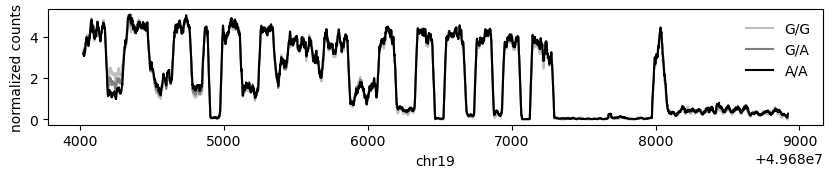

In [258]:
plot_gene('ENSG00000173531', 'Liver', 'chr3_49660026_G_A_b38', plot_var=False, smooth=20)

130053316
130018539


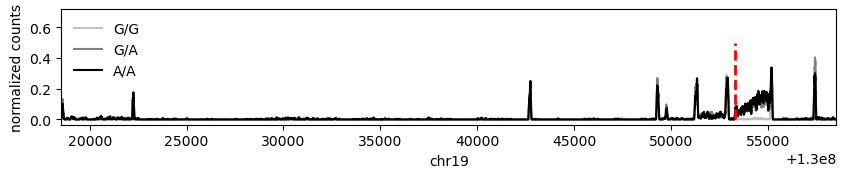

In [264]:

plot_gene('ENSG00000198945', 'Whole_Blood', 'chr6_130053316_T_A_b38', var_h=0.5, xlim = 40000)

In [262]:
130018539 - 130053316

-34777

In [246]:
import tabix

# chr8_11844613_alzheimer_disease # GCST004630	
tb_ = tabix.open('../code/GCST009325.for_visualization.bed.gz')

#chr12_54292096_GCST004630	2	Whole_Blood;ENSG00000135486.isoform_5,
#chr12_54292096_C_T_b38
records_ = tb_.query("chr1", 22938567-1500000, 22938567+1500000)

In [247]:
pos_list = []
pval_list = []
beta_list = []
se_list = []
var_list = []
for record in records_:

    pos = int(record[1])
    pval = float(record[3])
    # beta = float(record[6])
    # se = float(record[7])
    pos_list.append(pos)
    pval_list.append(pval)
    # beta_list.append(beta)
    # se_list.append(se)

    var = record[4]#.split('_')
    # var = ['chr' + var[0], var[1], var[2], var[3]]

    # var_change = [x.upper() for x in var[2:]]

    var += '_b38'#'_'.join([record[0], record[1], var_change[0], var_change[1]]) + '_b38'
    
    var_list.append(var)

In [248]:
ad_df = pd.DataFrame()
ad_df['pos'] = pos_list
ad_df['pval'] = pval_list
# ad_df['beta'] = beta_list
# ad_df['se'] = se_list
ad_df['var_id'] = var_list

In [249]:

tb_ = tabix.open('../code/QTLs/GTEx_10/Skin_Not_Sun_Exposed_Suprapubic/transcripts_10.ForGWASColoc.NominalPass.txt.tabix.gz')
records_ = tb_.query("chr1", 22938567-1500000, 22938567+1500000)

pos_list = []
pval_list = []
beta_list = []
se_list = []
var_list = []
    
for record in records_:
    if ('ENSG00000204219.isoform_7' in record[0]) and ('chr1_22938567_N_N_GCST004624' in record[0]):
        pos = int(record[10])
        pval = float(record[11])
        beta = float(record[13])
        se = float(record[14])
        pos_list.append(pos)
        pval_list.append(pval)
        beta_list.append(beta)
        se_list.append(se)
        var_list.append(record[7])

In [250]:
brain_df = pd.DataFrame()
brain_df['pos'] = pos_list
brain_df['pval'] = pval_list
brain_df['beta'] = beta_list
brain_df['se'] = se_list
brain_df['var_id'] = var_list

In [251]:
merged_df = ad_df.merge(brain_df, left_on = 'var_id', right_on='var_id')#.drop_duplicates()

Text(0, 0.5, '-log10 pval ENSG00000213949 Intron Retention')

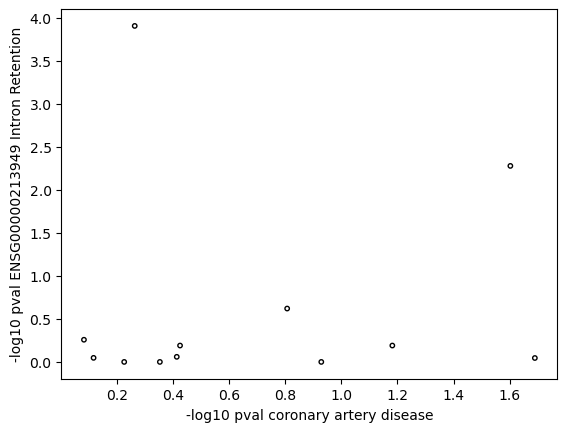

In [252]:
plt.scatter(np.array(-np.log10(merged_df.pval_x)), np.array(-np.log10(merged_df.pval_y)), facecolor='none', edgecolor='black', s=10)
plt.scatter(np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr1_23383982_C_T_b38'].pval_x)), 
            np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr1_23383982_C_T_b38'].pval_y)), c='red')

# plt.text(np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr5_52897294_A_G_b38'].pval_x)+0.5), 
#             np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr5_52897294_A_G_b38'].pval_y)-0.2), 'apaQTL', c='red')

# plt.scatter(np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr17_15976596_C_T_b38'].pval_x)), 
#             np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr17_15976596_C_T_b38'].pval_y)), c='purple')

# plt.text(np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr17_15976596_C_T_b38'].pval_x)-2), 
#             np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr17_15976596_C_T_b38'].pval_y)+0.5), 'rs12151021', c='purple')

plt.xlabel("-log10 pval coronary artery disease")
plt.ylabel('-log10 pval ENSG00000213949 Intron Retention')

In [253]:
brain_df

,pos,pval,beta,se,var_id
0,22438671,1.000000,0.000000,0.000000,chr1_22438671_C_T_b38
1,22438731,0.507561,0.184774,0.277755,chr1_22438731_C_G_b38
2,22438860,0.919709,0.078082,0.772492,chr1_22438860_T_G_b38
3,22439087,0.453992,0.411735,0.547546,chr1_22439087_C_T_b38
4,22439113,0.723939,-0.139015,0.392385,chr1_22439113_G_A_b38
...,...,...,...,...,...
22158,23438051,1.000000,0.000000,0.000000,chr1_23438051_G_A_b38
22159,23438407,0.282036,0.484842,0.448056,chr1_23438407_T_C_b38
22160,23438457,1.000000,0.000000,0.000000,chr1_23438457_A_G_b38
22161,23438470,0.419320,0.317403,0.391256,chr1_23438470_T_A_b38


In [270]:


import tabix

# chr8_11844613_alzheimer_disease # GCST004630	
tb_ = tabix.open('../code/coronary_for_visualization.bed.gz')

#chr12_54292096_GCST004630	2	Whole_Blood;ENSG00000135486.isoform_5,
#chr12_54292096_C_T_b38
records_ = tb_.query("chr5", 52897294-500000, 52897294+500000)

pos_list = []
pval_list = []
beta_list = []
se_list = []
var_list = []
for record in records_:

    pos = int(record[1])
    pval = float(record[3])
    # beta = float(record[6])
    # se = float(record[7])
    pos_list.append(pos)
    pval_list.append(pval)
    # beta_list.append(beta)
    # se_list.append(se)

    var = record[4].split(':')
    # var = ['chr' + var[0], var[1], var[2], var[3]]

    var_change = [x.upper() for x in var[2:]]

    var = '_'.join([record[0], record[1], var_change[1], var_change[0]]) + '_b38'
    
    var_list.append(var)


ad_df = pd.DataFrame()
ad_df['pos'] = pos_list
ad_df['pval'] = pval_list
# ad_df['beta'] = beta_list
# ad_df['se'] = se_list
ad_df['var_id'] = var_list

In [269]:
tb_ = tabix.open('../code/QTLs/GTEx_10/Heart_Atrial_Appendage/transcripts_10.ForGWASColoc.NominalPass.txt.tabix.gz')
records_ = tb_.query("chr5", 52897294-500000, 52897294+500000)

pos_list = []
pval_list = []
beta_list = []
se_list = []
var_list = []
    
for record in records_:
    if ('ENSG00000213949.isoform_8' in record[0]) and ('chr5_52897294_N_N_coronary_artery_disease' in record[0]):
        pos = int(record[10])
        pval = float(record[11])
        beta = float(record[13])
        se = float(record[14])
        pos_list.append(pos)
        pval_list.append(pval)
        beta_list.append(beta)
        se_list.append(se)
        var_list.append(record[7])

In [271]:
tb_ = tabix.open('../code/QTLs/GTEx_10/Liver/snmf_10.GroupedNominalPass.txt.tabix.gz')
records_ = tb_.query("chr5", 52897294-500000, 52897294+500000)

pos_list = []
pval_list = []
beta_list = []
se_list = []
var_list = []
    
for record in records_:
    if ('ENSG00000213949.factor_8' in record[5]):
        pos = int(record[11])
        pval = float(record[13])
        beta = float(record[14])
        se = float(record[15])
        pos_list.append(pos)
        pval_list.append(pval)
        beta_list.append(beta)
        se_list.append(se)
        var_list.append(record[9])

In [272]:
brain_df = pd.DataFrame()
brain_df['pos'] = pos_list
brain_df['pval'] = pval_list
brain_df['beta'] = beta_list
brain_df['se'] = se_list
brain_df['var_id'] = var_list

In [247]:
record

['ENSG00000164172',
 'chr5',
 '53095630',
 '53109806',
 '-',
 'ENSG00000164172.factor_9',
 '6',
 '709',
 '-9993',
 'chr5_53119799_A_G_b38',
 'chr5',
 '53119799',
 '53119799',
 '1',
 '0',
 '0',
 '0',
 '0']

In [273]:
merged_df = ad_df.merge(brain_df, left_on = 'var_id', right_on='var_id')#.drop_duplicates()ad_df

In [274]:
merged_df

,pos_x,pval_x,var_id,pos_y,pval_y,beta,se
0,52778499,0.007972,chr5_52778499_A_G_b38,52778499,0.202212,0.017428,-0.078514
1,52778567,0.028070,chr5_52778567_T_G_b38,52778567,0.155191,0.021605,-0.104782
2,52779062,0.024100,chr5_52779062_A_C_b38,52779062,0.540337,0.004045,-0.041233
3,52779082,0.299600,chr5_52779082_T_C_b38,52779082,0.906153,0.000150,0.025932
4,52779351,0.381500,chr5_52779351_C_G_b38,52779351,0.546431,0.003925,-0.044672
...,...,...,...,...,...,...,...
648,52967941,0.947300,chr5_52967941_T_C_b38,52967941,0.291562,0.011954,-0.208031
649,52968030,0.755700,chr5_52968030_T_G_b38,52968030,0.431852,0.006657,-0.060267
650,52968323,0.115200,chr5_52968323_A_C_b38,52968323,0.875788,0.000264,0.012028
651,52968687,0.783700,chr5_52968687_A_T_b38,52968687,0.021688,0.055385,-0.696507


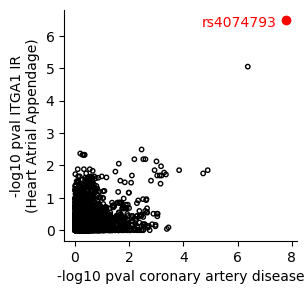

In [268]:
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(np.array(-np.log10(merged_df.pval_x)), np.array(-np.log10(merged_df.pval_y)), facecolor='none', edgecolor='black', s=10)
ax.scatter(np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr5_52897294_A_G_b38'].pval_x)), 
            np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr5_52897294_A_G_b38'].pval_y)), c='red')
ax.text(np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr5_52897294_A_G_b38'].pval_x))-3.1, 
            np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr5_52897294_A_G_b38'].pval_y))-0.2, 'rs4074793', c='red')
ax.set_xlabel("-log10 pval coronary artery disease")
ax.set_ylabel('-log10 pval ITGA1 IR\n(Heart Atrial Appendage)')
ax.spines[['top', 'right']].set_visible(False)

plt.savefig('../code/scratch_figures/figure4/ITGA1_CAD_coloc_heart.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure4/ITGA1_CAD_coloc_heart.png', bbox_inches='tight', dpi=500)

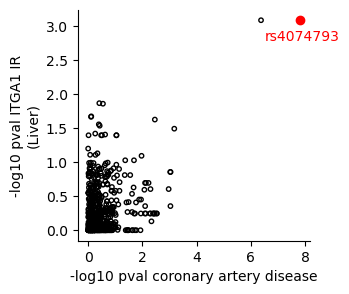

In [285]:
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(np.array(-np.log10(merged_df.pval_x)), np.array(-np.log10(merged_df.pval_y)), facecolor='none', edgecolor='black', s=10)
ax.scatter(np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr5_52897294_A_G_b38'].pval_x)), 
            np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr5_52897294_A_G_b38'].pval_y)), c='red')
ax.text(np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr5_52897294_A_G_b38'].pval_x))-1.3, 
            np.array(-np.log10(merged_df.loc[merged_df.var_id == 'chr5_52897294_A_G_b38'].pval_y))-0.3, 'rs4074793', c='red')
ax.set_xlabel("-log10 pval coronary artery disease")
ax.set_ylabel('-log10 pval ITGA1 IR\n(Liver)')
ax.spines[['top', 'right']].set_visible(False)

plt.savefig('../code/scratch_figures/figure4/ITGA1_CAD_coloc_liver.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure4/ITGA1_CAD_coloc_liver.png', bbox_inches='tight', dpi=500)